# Q learning

## Betting task: the strong-willed gambler in a casino, with the probability of winning a bet equal to $p$

Rules of the game: at any time, you have a capital $x$ between 0 and $n$. $x$ is an integer.

You are strong-willed: if your capital $x\ge n$,  you leave the casino and you do not return. You keep your capital $x$, which is your final payoff. 

If $x=0$, then you have no more money, and you leave the casino with nothing. Your final payoff is 0. 

If $0 < x < n$, you bet. Your possible actions are to bet any integer amount between 1 and $x$, inclusive. you cannot bet more than you own, so your maximum bet is $x$.

Let your bet be $a$, such that $1 \le a \le x$. 

If you win,your next state is $x+a$; if you lose, your next state (amount of capital) is $x-a$.  

You win with probability $p$, which is fixed for the duration of your gambling session. 

Your expected next capital is therefore:

$$E[x'] = p (x+a) + (1-p)(x-a) = x + (2p-1)a$$

If $p< 1/2$, your expected next capital $x'$ is less than your current capital $x$: on average, you lose. But you can still leave the casino a winner if you are lucky.  What is your best betting policy for doing so? If your capital is $x$, what is the average amount of your final capital, if you follow an optimal policy? 

If $p>1/2$, the casino is generous, and on average pays you!  But you can still go bust and leave with zero if you are unlucky. Again, what is your best betting policy?

Different casinos may have different values of $p$. What is your optimal $Q$ function, given $n$ (your strong-willed choice of when to leave the casino) and $p$, the probability of winning when you bet, which is a constant value in th casino?



In [5]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

### The Cautious but Strong-Willed Gambler

Suppose that you are a cautious person who likes to place small bets: you decide that you only feel comfortable betting 1 unit on each turn, until you either reach a wealth of $n$, or $0$.  What is your expected winnings with this policy? Is the optimal policy better? By how much? 



### Finding the optimal gambling policy

In [6]:
def optimal_action(Q,x):
    # finds the optimal 
    n = Q.shape[0]
    if x <= 0:
        return 0 # no bets possible with zero wealth
    elif x >=n: 
        return 0 # game is over, gambler has left casino
    else: 
        return np.argmax( Q[x,1:x+1]) + 1 # note that we have extracted a slice starting at index 1, so 
          # we need to add one to the index to retrieve the correct index within the Q matrix
        
def optimal_policy(Q):
    # returns a list of optimal action in each state
    n = Q.shape[0]
    return [ optimal_action(Q,x) for x in range(0,n) ]


In [7]:

def state_value( Q, x):
    n = Q.shape[0]
    assert x >= 0 
    if x == 0: # all money lost
        return 0 
    elif  x >= n:
        return x # the strong-willed gambler leaves the casino 
                # when wealth >= n 
    else:   
        return np.max( Q[x,1:x+1]) # return the largest Q value for 
                            # the best action in the next state

In [8]:
# Value iteration - apply all possible experiences once
def value_iterate( Q, p=0.5):
    n = Q.shape[0]
    for x in range(1,n):
        for a in range(1,x+1): # we can bet our entire fortune x on one throw
            Q[x,a] = p * state_value(Q,x+a) + (1-p) * state_value(Q,x-a)

In [9]:
n = 4
p = 0.3
# Q[x,a] is the Q value for wealth x and a bet of a

# when x reaches n or above, the game is over and the final payoff is received
Q = np.zeros([n,n])

In [10]:
for i in range(0,100):
    value_iterate(Q,p=p)

In [11]:
plt.plot(range(1,n),Q[n-1,1:])
plt.plot(range(1,n-1),Q[n-2,1:n-1])

You may find this graph quite confusing: the x axis is the size of the bet: the y axis is the optimal Q value for this bet, from the state you are in, which is $n-1$. 

Can you see intuitively why the Q value decreases for larger bets?  Can you see intuitively why the Q value starts to increase again, for very large bets? 

What should the Q value be for betting all of your capital: can you work this out directly by hand? 

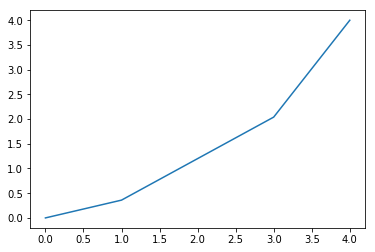

In [12]:
# Now plot the optimal values of states: that

values = [ state_value(Q,x) for x in range(0,n+1)]

plt.plot( range(0,n+1), values)

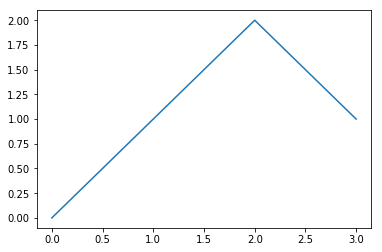

In [13]:
policy = optimal_policy(Q)

plt.plot( policy )

### Q learning

Now try Q learning. This formulation makes it clear that Q learning is a randomised form of value iteration. 

You may need a large number of trials to 'learn' a Q function close to the optimal one computed by value iteration. How many? 

This formulation of Q learning is 'off policy'.  Can you try to write an 'on policy' version (this will test your Python programming skills...) 

In [10]:
from random import randint

n = 20
p = 0.2
# Q[x,a] is the Q value for wealth x and a bet of a

# when x reaches n or above, the game is over and the final payoff is received
Q = np.zeros([n,n])

In [11]:
n_trials = 1000 # you will need to make this much larger

learning_rate = 0.1 # start large, then make it smaller

for i in range(0,n_trials):
    x = randint(1,n-1)
    a = randint(1,x)
    if np.random.rand() < p:
        xprime = x+a
    else:
        xprime = x-a   
    Q[x,a] = (1-learning_rate)*Q[x,a] + learning_rate * state_value(Q,xprime)

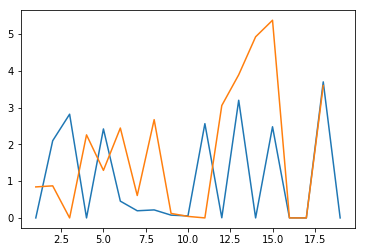

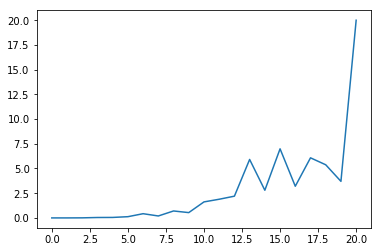

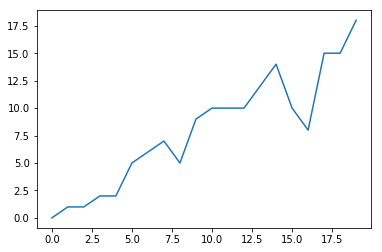

In [12]:
plt.plot(range(1,n),Q[n-1,1:])
plt.plot(range(1,n-1),Q[n-2,1:n-1])
plt.show()

# Now plot the optimal values of states: that

values = [ state_value(Q,x) for x in range(0,n+1)]

plt.plot( range(0,n+1), values)
plt.show()

policy = optimal_policy(Q)

plt.plot( policy )
plt.show()

In [19]:
class Env:
  def __init__(self, initial_value, goal):
    self.x = initial_value
    self.n = goal
    self._x = initial_value
    print("Initial State: {0}, GOAL: {1}".format(initial_value, goal))
  
  def step(self, action):
    # check if the agent has reached to the goal at by previous action
    if not self._check_state():
      bet = self._check_action(action)

      # say, if the bet was 0, then GAME_OVER
      if bet > 0:
        state = self.x

        # randomly pick next state from the uniform distribution
        # min: x - bet
        # max: x + bet
        next_state = np.random.choice(np.arange(state+bet), p=np.ones(state+bet)/float(state+bet))

        # if you win, a positive reward, if you loose, then a negative reward
        reward = next_state - self.x

        # game has not ended yet
        done = False

        # update the state of the env
        self.x = next_state
        
        if next_state == 0:
          state, next_state, reward, done = 0.0, 0.0, 0.0, True
      else:
        # GAME_OVER
        print("===== GAME_OVER =====")
        state, next_state, reward, done = 0.0, 0.0, 0.0, True
    else:
      print("===== YOU WON!! =====")
      state, next_state, reward, done = 0.0, 0.0, 0.0, True
      
    return state, next_state, reward, done
  
  def reset(self):
    # reset the deposit amount by initial value
    print("===== RESTART GAME =====")
    self.x = self._x
    return self.x
  
  def _check_action(self, action):
    if self.x >= action:
      return action
    else:
      return self.x

  def _check_state(self):
    if self.x >= self.n:
      return True
    else:
      return False

  def random_action(self):
    if self.x == 0:
      return 0

    temp = np.random.choice(np.arange(self.x), p=np.ones(self.x)/float(self.x))
    if temp == 0:
      return 1
    else:
      return temp


In [20]:
from collections import defaultdict
import numpy as np
import sys
import itertools

class Q_Learning:
  def __init__(self, env, epsilon=0.1, decay_rate=0.99, discount_factor=1.0, num_episodes=10, alpha=0.5):
    self.env = env
    self.num_episodes = num_episodes
    self.epsilon = epsilon
    self.decay_rate = decay_rate
    self.Q = defaultdict(lambda: np.zeros(env.x))
    self.stats = np.zeros((num_episodes, 2))
    self.discount_factor = discount_factor
    self.alpha = alpha

  def epsilon_policy(self, observation):
    A = np.ones(self.env.x, dtype=float) * self.epsilon/self.env.x
    optimal_action = np.argmax(Q[observation])
    A[optimal_action] += 1 - self.epsilon
    return A

  def _epsilon_decay(self):
    self.epsilon *= self.decay_rate

  def play(self):
    # play
    for i in range(self.num_episodes):
      # this satisfies the exploraing start condition
      state = env.reset()

      # behaviour policy
      action = np.random.choice(np.arange(env.x), p=self.epsilon_policy(state))

      # generate an episode
      for t in itertools.count():
        state, next_state, reward, done = env.step(action)
        
        if next_state == 0.0:
          print("State: {0}, Action: {1}, Next_State: {2}, Reward: {3}, done: {4}".format(state, action, next_state, reward, done))
          break
        
        next_action = np.argmax(Q[next_state])
        Q[state][action] += self.alpha * (reward + self.discount_factor * Q[next_state][next_action] - Q[state][action])

        self.stats[i, 0] = t
        self.stats[i, 1] += reward

        if done:
            break
        else:
          print("State: {0}, Action: {1}, Next_State: {2}, Reward: {3}, done: {4}".format(state, a, next_state, reward, done))

        state = next_state
        action = next_action

# TEST
initial_value = 5
goal = 10

env = Env(initial_value, goal)
agent = Q_Learning(env)
agent.play()

Initial State: 5, GOAL: 10
===== RESTART GAME =====
===== GAME_OVER =====
State: 0.0, Action: 0, Next_State: 0.0, Reward: 0.0, done: True
===== RESTART GAME =====
State: 5, Action: 4, Next_State: 6, Reward: 1, done: False
State: 6, Action: 4, Next_State: 2, Reward: -4, done: False
State: 2, Action: 4, Next_State: 3, Reward: 1, done: False
===== GAME_OVER =====
State: 0.0, Action: 0, Next_State: 0.0, Reward: 0.0, done: True
===== RESTART GAME =====
State: 5, Action: 4, Next_State: 6, Reward: 1, done: False
State: 6, Action: 4, Next_State: 7, Reward: 1, done: False
State: 7, Action: 4, Next_State: 7, Reward: 0, done: False
State: 7, Action: 4, Next_State: 9, Reward: 2, done: False
State: 9, Action: 4, Next_State: 10, Reward: 1, done: False
===== YOU WON!! =====
State: 0.0, Action: 10, Next_State: 0.0, Reward: 0.0, done: True
===== RESTART GAME =====
State: 5, Action: 4, Next_State: 1, Reward: -4, done: False
State: 1, Action: 1, Next_State: 0, Reward: -1, done: False
===== RESTART GAME =

## Random Action

In [ ]:
initial_value = 8
goal = 10

env = Env(initial_value, goal)

while True:
  a = env.random_action()
  state, next_state, reward, done = env.step(a)
  if done:
    break
  else:
    print("State: {0}, Action: {1}, Next_State: {2}, Reward: {3}, done: {4}".format(state, a, next_state, reward, done))

## Q-learning

In [ ]:
initial_value = 8
goal = 10

env = Env(initial_value, goal)
agent = Q_Learning(env)
agent.play()